In [1]:
"ready"

"ready"

In [2]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [3]:
m = 1.
g = 1.
ℓ = 1.
k = 1.
α = g / ℓ

# vector field for the Elastic Pendulum
# q = x, p = m * ℓ^2 * ẋ
function hamiltonian(p, q)
    return m*g*ℓ * (1 - cos(q)) + p^2 / (2*m*ℓ^2)
end

function pendulum_true_vf(x, ẋ)
    return [ẋ, - g / ℓ * sin(x)]
end



intial_cdts = []
x0 = π/4
ẋ0 = 0.

initial_cdts = [(x0, ẋ0)]
T = 3.
num_samples = 5
x_t1, ẋ_t1 = solve_ode(pendulum_true_vf, [ x0, ẋ0]; verbose=true, tspan = (0., T), length=num_samples)

x0 = .9 * π
ẋ0 = 0.
x_t2 , ẋ_t2 = solve_ode(pendulum_true_vf, [x0, ẋ0]; verbose=true, tspan = (0., T), length=num_samples)
initial_cdts = [initial_cdts..., (x0, ẋ0)]

x_t = [x_t1..., x_t2...]
ẋ_t = [ẋ_t1..., ẋ_t2...]
ẍ_t = -g/ℓ * sin.(x_t)

#ẋ_t = randn(num_samples) * π
#x_t = randn(num_samples) * π
ε = 1e-2 
noise_t = (ε) -> randn(size(x_t, 1)) .* ε
#, x_t = 
size(x_t), size(noise_t(ε))

Solving ODE from x0=[0.7853981633974483, 0.0]
size(sol) = (2, 12)
length = 5
Solving ODE from x0=[2.827433388230814, 0.0]
size(sol) = (2, 11)
length = 5


((10,), (10,))

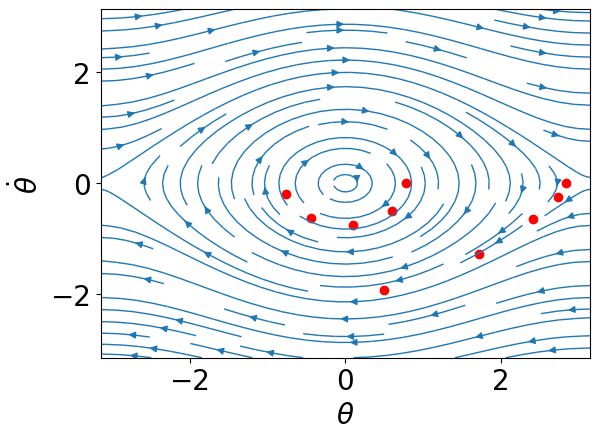

PyObject Text(44.472222222222214, 0.5, '$\\dot\\theta$')

In [5]:
pyplot(size = (400,400))
plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
PyPlot.scatter(x_t, ẋ_t,  color=:red)
PyPlot.xlabel("\$\\theta\$")
PyPlot.ylabel("\$\\dot\\theta\$")

# Learn a polynomial vector field

In [6]:
@polyvar x y

function learn_polynomial_vf(x_t, ẋ_t, ẍ_t; 
        max_deg=6, sym=false, sign_constraints=false) 
    # q = x, p = m * ℓ^2 * ẋ
    monomials = [x^i * y^j for i=0:max_deg for j=0:max_deg if i+j <= max_deg]

    model = SOSModel(with_optimizer(Mosek.Optimizer, LOG=0))
    @variable model c[1:size(monomials, 1)]
    @variable model γ

    f = c' * monomials

    #@constraint H(1, 1)
    if sym
        @constraint model coefficients(f + f(x => -x, y => -y)) .== 0
    end
    if sign_constraints
        S = @set x >= 0
        @constraint model f <= 0 domain = S
        S = @set x <= 0
        @constraint model f >= 0 domain = S
    end
    
    error_term = ẍ_t  - f.(x_t, ẋ_t)
    @constraint model [γ, error_term...] in SecondOrderCone()
    @objective model Min γ
    optimize!(model)
    return value(γ) / size(error_term, 1), [y, value(f)]
end
                
function learn_hamiltonian_vf(x_t, ẋ_t, ẍ_t; 
                        max_deg=6, sym=false, sign_constraints=false)
    # y => ẋ
    max_deg = max_deg + 1
    monomials = [x^i * y^j for i=0:max_deg for j=0:max_deg if i+j < max_deg && i + j > 0]
    model = SOSModel(with_optimizer(Mosek.Optimizer, LOG=0))
    @variable model c[1:size(monomials, 1)]
    @variable model γ
    H = monomials' * c
    Hx = differentiate(H, x)
    Hy = differentiate(H, y)
    f = [Hy, -Hx]
    error_term = [
        (ẋ_t - f[1].(x_t, ẋ_t))...,
        (ẍ_t - f[2].(x_t, ẋ_t))...
    ]   

    @constraint model [γ, error_term...] in  SecondOrderCone()
    @objective model Min γ
                                    
    if sym
        @constraint model coefficients(H - H(x => x, y => -y)) .== 0
        @constraint model coefficients(H - H(x => -x, y => y)) .== 0
    end
    if sign_constraints
        S = @set x >= 0 && x <= 3.14
        @constraint model f[2] <= 0 domain = S
        S = @set x <= 0 && x >= -3.14
        @constraint model f[2] >= 0 domain = S
    end
    optimize!(model)
    
    return value(γ) / size(error_term, 1), value.(H), value.(f)
end

function compare_learned_vf_to_true_vf(f_value)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    figure(figsize=(10,5))
    subplot(121)
    learned_vf_plot = plot_vectorfield(learned_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.scatter(x_t, ẋ_t, color=:red)
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")

    subplot(122)
    true_vf_plot = plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")
end

compare_learned_vf_to_true_vf (generic function with 1 method)

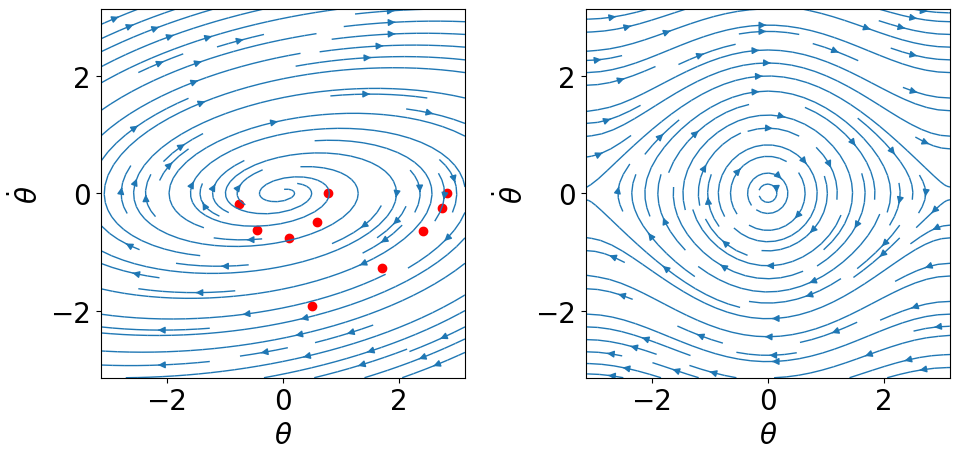

0.11447043737914224

In [7]:
ẍ_t = -g/ℓ * sin.(x_t)
ε = .1
Random.seed!(0)
error, f_value = learn_polynomial_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=2,
                                    sym=true,
                                    sign_constraints=false)
compare_learned_vf_to_true_vf(f_value)
error

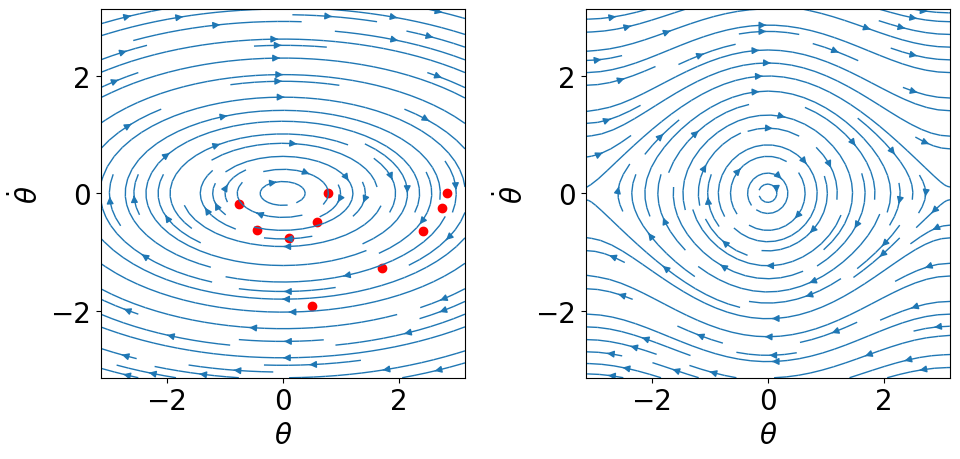

(0.06166429049400428, 0.13553277207713746x² + 0.5000000000000002y²)

In [8]:
ε = 0.1
Random.seed!(0)
error, H_value, f_value = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=2,
                                    sym=true,
                                    sign_constraints=true)
compare_learned_vf_to_true_vf(f_value)
error, H_value

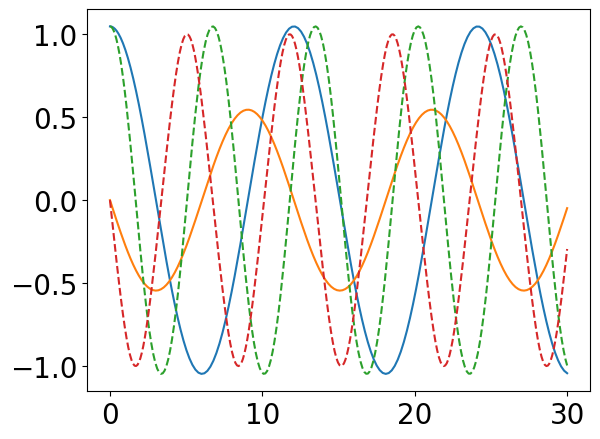

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f967e5fd5b0>
 PyObject <matplotlib.lines.Line2D object at 0x7f967e5fd6d0>

In [9]:
learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
poly_vf(u, p, t) = learned_vf(u...)
true_vf(u, p, t) = pendulum_true_vf(u...)

T_eval = 10*T
u₀ = [π/3, 0.]

prob = ODEProblem(true_vf, u₀, (0., T_eval))
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)


prob = ODEProblem(poly_vf, u₀, (0., T_eval))
poly_sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

pyplot()
PyPlot.figure()
PyPlot.plot(poly_sol.t, poly_sol.u)
PyPlot.plot(sol.t, sol.u, ls="dashed")

#Plots.plot!(learned_sol, vars=(7, 8), color=:red)
